# Chapter6 : Deep learning for text and sequences

This chapter explores deep-learning models that can process text, timeseries, and sequence data in general. The two fundamental deep-learning algorithms for sequence processing are *recurrent neural networks* and *1D convnets*.

  Applications of these algorithms include the following:
  + Document classification and timeseries classification, such as identifying the topic of an article or the author of a book
  + Timeseries comparisons, such as estimating how closely related two documents or two stock tickers are
  + Sequence-to-sequence learning, such as decoding an English sentence into French
  + Sentiment analysis, such as classifying the sentiment of tweets or movie review as positive or negative
  + Timeseries forecasting, such as predicting the future weather at a certain location, given recent weather data

## 6.1 Working with text data

Text is one of the most widespread forms of sequence data. Deep learning for natural-language processing is pattern recognition applied to words, sentences, and paragraphs, in much the same way that computer vision is pattern recognition applied to pixels.

Like all other neural networks, deep-learning models don't take as input raw text: they only work with numeric tensors. *Vectorizing* text is the process of transforming text into numeric tensors. This can be done in multiple ways:
  + Segment text into words, and transform each word into a vector.
  + Segment text into characters, and transform each character into a vector.
  + Extract n-grams of words or characters, and transform each n-gram into a vector.*N-grams* are overlapping groups of multiple consecutive words or characters.

Collectively, the different units into which you can break down text (words, characters, or n-grmas) are called *tokens*, and breaking text into such tokens is called *tokenization*. There are multiple ways to associate a vector with a token: *one-hot encoding* of tokens, and *token embedding*.

### 6.1.1 One-hot encoding of words and characters

#### Word-level one-hot encoding (toy example)

In [1]:
import numpy as np

In [2]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

In [3]:
token_index

{'The': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'the': 5,
 'mat.': 6,
 'dog': 7,
 'ate': 8,
 'my': 9,
 'homework.': 10}

In [4]:
max_length = 10
results = np.zeros(shape = (len(samples), max_length, max(token_index.values())+1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [5]:
results

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

#### Character-level one-hot encoding (toy example)

In [6]:
import string

In [7]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable   # all printable ASCII characters
token_index = dict(zip(range(1, len(characters)+1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys())+1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [8]:
results[0, :, :]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Using Keras for word-level one-hot encoding

In [9]:
from keras.preprocessing.text import Tokenizer

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [10]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000)  # creates a tokenizer, 
                                       # configured to only take into account the 1,000 most common words
tokenizer.fit_on_texts(samples)   # build the word index

sequences = tokenizer.texts_to_sequences(samples)   # turns strings into list of integer indices
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


#### Word-level one-hot encoding with hashing trick (toy example)

A variant of one-hot encoding is the so-called *one-hot hashing trick*, which you can use when the number of unique tokens in your vocabulary is too large to handle explicitly.

Instead of explicitly assigning an index to each word and keeping a reference of these indices in a dictionary, you can hash words into vectors of fixed size. This is typically done with a very lightweight hashing function. The main advantage of this method is that it does away with maintaining an explicit word index, which saves memory and allows online encoding of the data. The one drawback of this approach is that it's susceptible to *hash collisions*: two different words may end up with the same hash, and subsequently machine-learning algorithms won't be able to tell the difference between these words.

In [11]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality   # hashes the word into a
                                                   # random integer index between 0 and 1,000
        results[i, j, index] = 1.

#### Using word embedding

Another popular and powerful way to assiciate a vector with a word is the use of dense *word vectors*, also called *word embeddings*. Whereas the vectors obtained through one-hot encoding are binary, sparse, and very high-dimensional, word embeddings are low-dimensional floating-point vectors. Unlike the word vectors obtained via one-hot encoding, word embeddings are learned from data.

<img src="image/fig62.png">

There are two ways to obtain word embeddings:
  + Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
  + Load into your model word embeddings that were precomputed using a different machine-learning task than the one you're trying to solve. These are called *pretrained word embeddings*.

#### LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER

In [12]:
from keras.layers import Embedding

In [13]:
embedding_layer = Embedding(1000, 64)
# the embedding layer takes at leat two arguments:
# the number of possible tokens (1000),
# and the dimensionality of the embeddings (64)

The **Embedding** layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors

When you instantiate an **Embedding** layer, it weights are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure--a kind of structure specialized for the specific problem for which you'r training your model.

#### Loading the IMDB data for use with an Embedding layer

In [14]:
from keras.datasets import imdb
from keras import preprocessing

In [15]:
max_features = 10000   # number of words to consider as features
maxlen = 20   # cuts off the text after this number of words

In [16]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

In [17]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

#### Using an Embedding layer and classifier on the IMDB data

In [18]:
from keras import models
from keras import layers

In [19]:
model = models.Sequential()

model.add(layers.Embedding(10000, 8, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 3s - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
 - 2s - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
 - 1s - loss: 0.4752 - acc: 0.7808 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
 - 2s - loss: 0.4263 - acc: 0.8077 - val_loss: 0.5008 - val_acc: 0.7452
Epoch 5/10
 - 2s - loss: 0.3930 - acc: 0.8258 - val_loss: 0.4981 - val_acc: 0.7538
Epoch 6/10
 - 2s - loss: 0.3668 - acc: 0.8395 - val_loss: 0.5014 - val_acc: 0.7530
Epoch 7/10
 - 2s - loss: 0.3435 - acc: 0.8533 - val_loss: 0.5052 - val_acc: 0.7520
Epoch 8/10
 - 2s - loss: 0.3223 - acc: 0.8657 - val_loss: 0.5132 - val_acc: 0.7486
Epoch 9/10
 - 2s - loss: 0.3022 - acc: 0.8766 - val_loss: 0.5213 - val_acc: 0.7490
Epoch 10/10
 - 1s - loss: 0.2839 - acc: 0.8860 - val_loss: 0.5303 - val_acc: 0.7466


> You get to a validation accuracy of almost 75%, which is pretty good considering that you're only looking at the first 20 words in every review.

But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input separately, **without considering inter-word relationships and sentence structure**.

It's much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole.

#### USING PRETRAINED WORD EMBEDDING

Instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties--that captures generic aspects of language structure.

The rationale behind using pretrained word embeddings in natural-language processing is much the same as for using pretrained convnets in image classification: you don't have enough data available to learn truly powerful features on you own, but you expect the features that you need to be fairly generic.

There are various precomputed databases of word embeddings that you can download and use in a Keras Embedding layer, such as Word2vec and GloVe.

### 6.1.3 Putting it all together: from raw text to word embeddings

#### DOWNLOADING THE IMDB DATA AS RAW TEXT

First, head to http://mng.bz/0tIo and download the raw IMDB dataset.

#### Processing the labels of the raw IMDB data

In [21]:
import os
imdb_dir = 'C:/Users/jeong/Documents/GITHUB/DeepLearningWithPython/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [22]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [23]:
texts[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

#### TOKENIZING THE DATA

Let's vectorize the text and prepare a training and validation split. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available, we'll restrict the training data to the first 200 samples. So you'll learn to classify movie reviews after looking at just 200 examples.

#### Tokenizing the text of the raw IMDB data

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [25]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [26]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens' %len(word_index))

Found 88582 unique tokens


In [27]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [28]:
# before spliting the data, shuffle the data because the samples are ordered
# (all negatives first, then all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [29]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

#### DOWNLOADING THE GloVe WORD EMBEDDINGS

Go to https://nlp.stanford.edu/projects/glove/, and download the precomputed embeddings from 2014 English Wikipedia.

#### PREPROCESSING THE EMBEDDINGS
#### Parsing the GloVe word-embeddings file

In [30]:
glove_dir = 'C:/Users/jeong/Documents/GITHUB/DeepLearningWithPython/glove.6B'

In [31]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


#### Preparing the GloVe word-embeddings matrix

In [32]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(10000, 100)

In [34]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.13787   , -0.17727   , -0.62436002, ...,  0.35506001,
         0.33443999,  0.14436001],
       [-0.88968998,  0.55208999, -0.50498998, ..., -0.54351002,
        -0.21874   ,  0.51186001],
       [-0.17381001, -0.037609  ,  0.068837  , ..., -0.097167  ,
         1.08840001,  0.22676   ]])

#### DEFINING A MODEL

#### Model definition

In [35]:
from keras import models, layers

In [36]:
model = models.Sequential()

model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### LOADING THE GLoVe IN THE MODEL

#### Loading pretrained word embedding into the Embedding layer

You'll freese the Embedding layer, following the same rationale you're already familiar with in the context of pretrained convnet features: when parts of a model are pretrained and parts are randomly initialized, the pretrained parts shouldn't be updated during training, to avoid forgetting what they already know.

In [37]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#### TRAINING AND EVALUATING THE MODEL

#### Training and evaluation

In [38]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=2)

Train on 200 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 1.6331 - acc: 0.5250 - val_loss: 0.7130 - val_acc: 0.5100
Epoch 2/10
 - 1s - loss: 0.7565 - acc: 0.5800 - val_loss: 0.6910 - val_acc: 0.5418
Epoch 3/10
 - 1s - loss: 0.5956 - acc: 0.6950 - val_loss: 1.1205 - val_acc: 0.4936
Epoch 4/10
 - 1s - loss: 0.5335 - acc: 0.7350 - val_loss: 0.7134 - val_acc: 0.5362
Epoch 5/10
 - 1s - loss: 0.4713 - acc: 0.8100 - val_loss: 0.7177 - val_acc: 0.5589
Epoch 6/10
 - 1s - loss: 0.1448 - acc: 0.9800 - val_loss: 1.3373 - val_acc: 0.4952
Epoch 7/10
 - 1s - loss: 0.2545 - acc: 0.8800 - val_loss: 1.3110 - val_acc: 0.4960
Epoch 8/10
 - 1s - loss: 0.1102 - acc: 0.9800 - val_loss: 0.8168 - val_acc: 0.5558
Epoch 9/10
 - 1s - loss: 0.0760 - acc: 0.9800 - val_loss: 1.5204 - val_acc: 0.5115
Epoch 10/10
 - 1s - loss: 0.0680 - acc: 0.9850 - val_loss: 0.7458 - val_acc: 0.5759


In [39]:
model.save_weights('pre_trained_glove_model.h5')

#### Plotting the results

In [40]:
import matplotlib.pyplot as plt

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

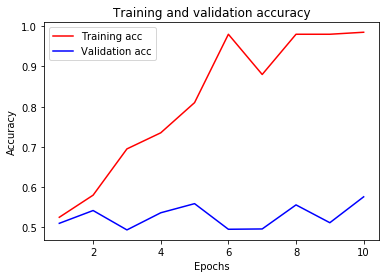

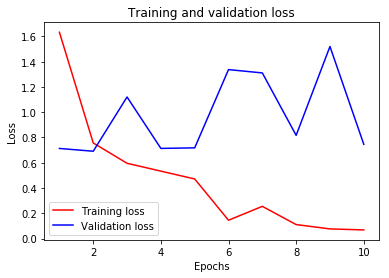

In [42]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> The model quickly starts overfitting, which is unsurprising given the small number of training samples. Validation accuracy has high variance for the same reason, and it reaches an accuracy of about 58%.

You can also train the same model without loading the pretrained word embeddings and without freezing the embedding layer. In that case, you'll learn a task-specific embedding f the input tokens, which is generally more powerful than pretrained word embeddings when lots of data is available.

#### Training the same model without pretrained word embeddings

In [43]:
from keras import models, layers

In [44]:
model = models.Sequential()

model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=2)

Train on 200 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.6951 - acc: 0.4350 - val_loss: 0.6950 - val_acc: 0.5167
Epoch 2/10
 - 1s - loss: 0.5028 - acc: 0.9800 - val_loss: 0.7054 - val_acc: 0.5069
Epoch 3/10
 - 1s - loss: 0.2898 - acc: 0.9850 - val_loss: 0.7012 - val_acc: 0.5187
Epoch 4/10
 - 1s - loss: 0.1183 - acc: 1.0000 - val_loss: 0.7166 - val_acc: 0.5156
Epoch 5/10
 - 1s - loss: 0.0524 - acc: 1.0000 - val_loss: 0.7150 - val_acc: 0.5288
Epoch 6/10
 - 1s - loss: 0.0261 - acc: 1.0000 - val_loss: 0.7249 - val_acc: 0.5260
Epoch 7/10
 - 1s - loss: 0.0141 - acc: 1.0000 - val_loss: 0.7211 - val_acc: 0.5389
Epoch 8/10
 - 1s - loss: 0.0082 - acc: 1.0000 - val_loss: 0.7390 - val_acc: 0.5267
Epoch 9/10
 - 1s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.7283 - val_acc: 0.5393
Epoch 10/10
 - 1s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.7476 - val_acc: 0.5313


In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

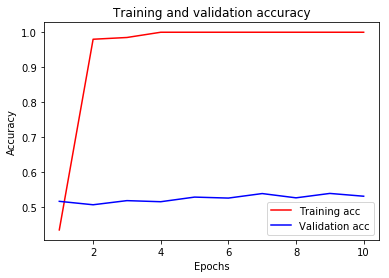

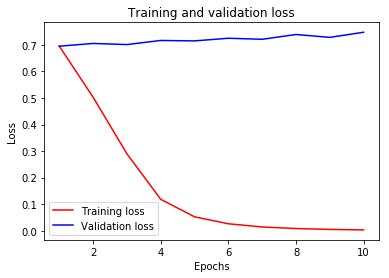

In [47]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> Validation accuracy stalls in the low 50s. So in this case, pretrained word embeddings outperform jointly learned embeddings.

#### Tokenizing the data of the test set

In [50]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [52]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

#### Evaluating the model on the test set

In [53]:
model.load_weights('pre_trained_glove_model.h5')

In [54]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 92us/step


[0.7448734399604797, 0.57604]

> You get an appalling test accuracy of almost 58%. Working with just a handful of training samples is difficult!!